# CSC412 Project (transformer generating part)
#### Author: Xinyi Ji

In [24]:
import torch
import torch.nn as nn
from torch.optim import Adam
import pandas as pd
import torch.utils.data as data
import pickle as pkl

### Data preprocessing

In [60]:
checkpt = torch.load('transformer_model.ckpt')

In [26]:
df = pd.read_csv('transformer_data.csv')
df.columns = range(256+1024)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
0,0,0,0,0,0,0,0,0,0,0,8,10,0,3,0,0,1,0,0,0,0,0,0,4,9,6,0,1,3,0,0,3,0,0,0,0,1,1,0,0,...,5232,209,2676,109,8031,127,4605,6384,510,3022,6271,2497,3224,4407,2006,5214,2629,5629,5214,5536,5643,4972,1177,1087,3414,5536,4547,7628,5239,1255,6583,7148,6565,3188,4312,6262,448,1732,215,4120
1,0,0,0,0,0,0,0,0,0,0,3,9,0,3,0,0,0,0,0,0,0,0,0,11,10,4,0,0,0,0,0,0,0,2,0,0,1,0,0,0,...,2557,1971,5385,30,2336,1778,199,560,6674,2532,7596,3123,2558,7453,5045,3927,2483,5698,2862,6165,5517,170,6460,5813,5897,3230,3533,7976,684,6770,1291,5470,3610,2133,6686,108,4834,3610,5542,1244
2,0,0,0,0,0,0,0,0,0,0,12,9,0,4,0,0,0,0,0,0,0,0,0,3,9,5,0,1,6,0,0,1,0,1,0,0,3,0,0,0,...,6791,4609,1917,3862,943,5916,1601,540,5363,4448,390,2560,2786,1147,4552,3916,671,2410,6791,6648,6875,7870,3830,3152,2114,5479,6443,6304,4283,6850,3441,6419,2014,390,4809,6227,5031,1680,1018,1309
3,0,0,0,0,0,0,0,0,0,2,8,9,0,4,0,0,1,0,0,0,0,0,0,5,8,5,0,1,2,0,0,1,0,1,0,0,4,0,0,0,...,6004,5403,7180,5668,2653,2327,5689,7781,6958,1600,7823,4007,6721,4621,4950,2690,5175,2684,2418,2952,3096,7012,4800,5477,2737,3851,7463,101,4583,7189,3404,5868,383,2548,6361,2576,2119,8011,4340,6000
4,0,0,0,0,0,0,0,0,0,0,7,11,0,1,0,0,0,0,0,0,0,0,0,3,8,6,0,0,2,0,0,2,0,1,0,0,1,0,0,1,...,4979,6587,6241,6473,4759,1830,5048,332,4472,2791,795,6322,6583,8148,5718,3759,5998,1534,5951,2849,4234,6101,6330,541,5978,2433,4950,5608,4165,5623,2177,2576,2464,825,4920,6289,61,4492,2061,704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0,0,0,0,0,0,0,0,0,13,0,9,0,3,0,0,0,0,0,0,0,0,0,0,10,3,0,0,2,0,0,1,0,0,0,0,0,0,0,0,...,5516,1929,7510,4785,6265,5156,5725,4155,2343,2063,6559,4736,3054,2190,2047,7133,5951,6710,8019,4734,5807,7022,5288,202,5650,1698,3959,2826,4377,10,2167,7537,6297,4441,7141,729,5452,4844,3572,6243
3996,0,0,0,0,0,0,0,0,0,14,0,9,0,3,0,0,0,0,0,0,0,0,0,0,10,4,0,2,3,0,0,0,0,0,0,0,0,0,0,0,...,2805,5466,5835,2161,2793,5573,5172,3754,7882,1672,2657,5324,4670,4442,7389,2924,8125,7468,4139,6310,7014,5782,1615,2448,1254,35,3454,225,1677,4575,5377,5668,4580,5891,6103,7455,7689,421,7673,2918
3997,0,0,0,0,0,0,0,0,0,15,0,10,0,2,0,0,0,0,0,0,0,0,0,0,10,3,0,1,2,0,0,2,0,0,0,0,0,0,0,0,...,4509,202,3071,6258,2831,4522,7673,3046,4106,592,6258,5623,4670,4419,7321,7451,1787,2896,960,4670,592,592,592,592,3260,592,592,2896,916,6295,4106,4522,2896,592,592,3260,7986,2896,2830,1938
3998,0,0,0,0,0,0,0,0,0,11,0,8,0,3,0,0,0,0,0,0,0,0,0,3,10,1,0,1,1,0,0,0,0,0,0,0,1,1,0,0,...,1304,6861,4305,4888,6958,7942,1950,1788,3641,7640,2756,3672,2736,5295,6363,3685,7697,1841,1415,615,7314,2080,7583,4748,6141,865,213,2707,4042,6928,7479,974,5778,7583,5375,15,5995,2399,7804,20


In [27]:
txt_col = range(256)
img_col = range(256,1024+256)
df_txt = df[txt_col]
df_img = df[img_col]
txt_array = df_txt.values
img_array = df_img.values
all_data = df.values
all_data = torch.from_numpy(all_data)

In [28]:
all_data.shape[0]

4000

In [29]:
def split_train_test(data, train_fraq=0.9): 
 n_samples = data.shape[0] 
 data_train = data[:int(n_samples * train_fraq)] 
 data_test = data[int(n_samples * train_fraq):] 
 return data_train, data_test 

In [30]:
all_data = split_train_test(all_data)

In [31]:
all_data[0].shape

torch.Size([3600, 1280])

In [32]:
train_X = all_data[0][:, :256]
train_y = all_data[0][:,256:]
test_X =  all_data[1][:, :256]
test_y = all_data[1][:,256:]

In [33]:
with open('./train_img_token1.pkl','rb') as f: first_token = pkl.load(f)

In [34]:
start_token = torch.tensor(first_token) # [3600]

In [35]:
start_token.shape

torch.Size([3600])

In [36]:
def dataloader(dataset, **kwargs): 
  if 'shuffle' not in kwargs: 
    kwargs['shuffle'] = True 
  if 'drop_last' not in kwargs: 
    kwargs['drop_last'] = True 
  if 'batch_size' not in kwargs: 
    kwargs['batch_size'] = 32 
  if 'num_workers' not in kwargs: 
    kwargs['num_workers'] = 8 
    kwargs['batch_size'] = min(kwargs['batch_size'], len(dataset)) 
  return data.DataLoader(dataset, **kwargs) 

In [37]:
# Train data is a tensor
batch_size = 10
num_workers = 8
train_dataset = data.TensorDataset(train_X, train_y, start_token) 
test_dataset = data.TensorDataset(test_X, test_y) 
train_dataloader = dataloader(train_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True) 
test_dataloader = dataloader(test_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for batch_idx, (x, y, z) in enumerate(train_dataloader):
  print(x)
  print(x.shape)
  print(y)
  print(y.shape)
  print(z)
  print(z.shape)
  print("----")

###  Transformer Model:

In [68]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        # Get number of training examples
        N = query.shape[0]

        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)  # (N, value_len, heads, head_dim)
        keys = self.keys(keys)  # (N, key_len, heads, head_dim)
        queries = self.queries(query)  # (N, query_len, heads, heads_dim)

        # Einsum does matrix mult. for query*keys for each training example
        # with every other training example, don't be confused by einsum
        # it's just how I like doing matrix multiplication & bmm

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim),
        # keys shape: (N, key_len, heads, heads_dim)
        # energy: (N, heads, query_len, key_len)

        # Mask padded indices so their weights become 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        # Normalize energy values similarly to seq2seq + attention
        # so that they sum to 1. Also divide by scaling factor for
        # better stability
        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        # attention shape: (N, heads, query_len, key_len)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out after matrix multiply: (N, query_len, heads, head_dim), then
        # we reshape and flatten the last two dimensions.

        out = self.fc_out(out)
        # Linear layer doesn't modify the shape, final shape will be
        # (N, query_len, embed_size)

        return out

In [69]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        # Add skip connection, run through normalization and finally dropout
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

In [70]:
class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length = 256,
    ):

        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        out = self.dropout(
            (self.word_embedding(x) + self.position_embedding(positions))
        )

        # In the Encoder the query, key, value are all the same, it's in the
        # decoder this will change. This might look a bit odd in this case.
        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

In [71]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.norm = nn.LayerNorm(embed_size)
        self.attention = SelfAttention(embed_size, heads=heads)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out

In [72]:
class Decoder(nn.Module):
    def __init__(
        self,
        trg_vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        device,
        max_length = 1024,
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device),
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device),
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device),
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device),
                DecoderBlock(embed_size, heads, forward_expansion, dropout, device)
            ]
        )
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, row_mask,col_mask,conv_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

        x = self.layers[0](x, enc_out, enc_out, src_mask, row_mask)
        x = self.layers[1](x, enc_out, enc_out, src_mask, col_mask)
        x = self.layers[2](x, enc_out, enc_out, src_mask, row_mask)
        x = self.layers[3](x, enc_out, enc_out, src_mask, row_mask)
        x = self.layers[4](x, enc_out, enc_out, src_mask, conv_mask)

        out = self.fc_out(x)

        return out

In [73]:
class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        trg_pad_idx,
        embed_size=512,
        num_layers=6,
        forward_expansion=4,
        heads=8,
        dropout=0,
        device="gpu",
        max_length=1024,
    ):

        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            256,
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            1024,
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)

    def make_row_mask(self, trg):
        N, trg_len = trg.shape

        # trg_len = 32 * 32 = 1024
        assert (
            1024 == trg_len
        ), "The size of image vector is 1024"

        y_axis = torch.range(0, 1023).expand(1024,1024)
        x_axis = torch.transpose(torch.range(0, 1023).expand(1024,1024), 0, 1)
        trg_mask = ((y_axis<x_axis).long() + (y_axis+32>x_axis).long() -1).bool()

        trg_mask = trg_mask.expand(N, 1, trg_len, trg_len)

        return trg_mask.to(self.device)
    
    def make_col_mask(self, trg):
        N, trg_len = trg.shape
        # trg_len = 32 * 32 = 1024

        assert (
            1024 == trg_len
        ), "The size of image vector is 1024"

        trg_mask = torch.zeros(1024, 1024)
        for i in range(32):
          cur_dia = torch.ones((1, 1024-32*i))[0]
          cur_mask = torch.diag(cur_dia,-32*i)
          trg_mask = trg_mask + cur_mask

        trg_mask = trg_mask.expand(N, 1, trg_len, trg_len)

        return trg_mask.to(self.device)
    
    def make_conv_mask(self, trg):
      # I am not sure how to deal with this(I searched online without finding the result),hence I will use row mask instead as they have similar performance
        N, trg_len = trg.shape
        # trg_len = 32 * 32 = 1024
        assert (
            1024 == trg_len
        ), "The size of image vector is 1024"

        y_axis = torch.range(0, 1023).expand(1024,1024)
        x_axis = torch.transpose(torch.range(0, 1023).expand(1024,1024), 0, 1)
        trg_mask = ((y_axis<x_axis).long() + (y_axis+32>x_axis).long() -1).bool()

        trg_mask = trg_mask.expand(N, 1, trg_len, trg_len)

        return trg_mask.to(self.device)

    def forward(self, src, trg):
        # src_mask = self.make_src_mask(src)
        # trg_mask = self.make_trg_mask(trg)

        src_mask = self.make_src_mask(src)
        row_mask = self.make_row_mask(trg)
        col_mask = self.make_col_mask(trg)
        conv_mask = self.make_conv_mask(trg)

        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, row_mask,col_mask,conv_mask)
        return out

### dVAE model

In [93]:
! pip install DALL-E

     |████████████████████████████████| 21.6MB 69.3MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 747kB 59.8MB/s 
     |████████████████████████████████| 1.9MB 53.1MB/s 
ERROR: blobfile 1.2.0 has requirement urllib3~=1.25, but you'll have urllib3 1.24.3 which is incompatible.


In [94]:

import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

target_image_size = 256

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

In [95]:
# This can be changed to a GPU, e.g. 'cuda:0'.
dev = torch.device('cpu')

# For faster load times, download these files locally and use the local paths instead.
enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", dev)
dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", dev)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:365: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


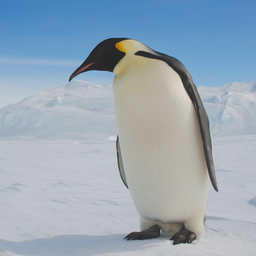

In [96]:
x = preprocess(download_image('https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg'))
display_markdown('Original image:')
display(T.ToPILImage(mode='RGB')(x[0]))

torch.Size([1, 32, 32])


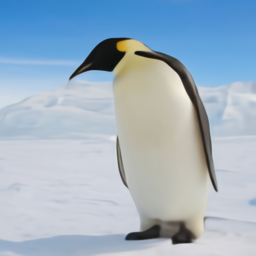

In [100]:
import torch.nn.functional as F

z_logits = enc(x)
z = torch.argmax(z_logits, axis=1)
print(z.shape)
z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()

x_stats = dec(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

display_markdown('Reconstructed image:')
display(x_rec)

In [99]:
z.shape

torch.Size([1, 8192, 32, 32])

### Generating part

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "gpu")
def make_src_mask(src):
  src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
  # (N, 1, 1, src_len)
  return src_mask.to(device)

def make_row_mask(trg):
  N, trg_len = trg.shape
  # trg_len = 32 * 32 = 1024
  assert (
      1024 == trg_len
  ), "The size of image vector is 1024"

  y_axis = torch.range(0, 1023).expand(1024,1024)
  x_axis = torch.transpose(torch.range(0, 1023).expand(1024,1024), 0, 1)
  trg_mask = ((y_axis<x_axis).long() + (y_axis+32>x_axis).long() -1).bool()

  trg_mask = trg_mask.expand(N, 1, trg_len, trg_len)

  return trg_mask.to(device)
    
def make_col_mask(trg):
  N, trg_len = trg.shape
  # trg_len = 32 * 32 = 1024

  assert (
      1024 == trg_len
  ), "The size of image vector is 1024"

  trg_mask = torch.zeros(1024, 1024)
  for i in range(32):
    cur_dia = torch.ones((1, 1024-32*i))[0]
    cur_mask = torch.diag(cur_dia,-32*i)
    trg_mask = trg_mask + cur_mask
    trg_mask = trg_mask.expand(N, 1, trg_len, trg_len)

    return trg_mask.to(device)
    
def make_conv_mask(trg):
  # I am not sure how to deal with this(I searched online without finding the result),hence I will use row mask instead as they have similar performance
  N, trg_len = trg.shape
  # trg_len = 32 * 32 = 1024
  assert (
      1024 == trg_len
  ), "The size of image vector is 1024"

  y_axis = torch.range(0, 1023).expand(1024,1024)
  x_axis = torch.transpose(torch.range(0, 1023).expand(1024,1024), 0, 1)
  trg_mask = ((y_axis<x_axis).long() + (y_axis+32>x_axis).long() -1).bool()
  trg_mask = trg_mask.expand(N, 1, trg_len, trg_len)

  return trg_mask.to(device)

In [90]:
def greedy_decode(model, src, src_mask, max_len, start_token, device):
    """
      Args:
        src: [bs, 1024]
        start_token : [bs]
        max_len : [1]
    """
    memory = model.encoder(src, src_mask)  # forward(self, x, mask)
    out_curr = torch.ones(src.shape[0], max_len).long().to(device)  # bs * 1024
    out_curr[: , 0] = start_token.long() # bs * 1024

    row_mask = make_row_mask(out_curr)
    col_mask = make_col_mask(out_curr)
    conv_mask = make_conv_mask(out_curr)

    for i in range(max_len - 1):
      out = model.decoder(out_curr, memory, src_mask, row_mask,col_mask,conv_mask)
      prob = out[:, i] # [bs, d_x]
      _, next_img = torch.max(prob, dim = 1) # [bs]
      out_curr[:, i + 1] = next_img.long() 
    return out_curr 

In [91]:
src_pad_idx = 0
trg_pad_idx = 0
src_vocab_size = 51
trg_vocab_size = 8192
model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device).to(device)

model.load_state_dict(checkpt["model"])
model.eval()
for batch_idx, (x, y, z) in enumerate(train_dataloader):
  x = x.to(device) 
  y = y.to(device) 
  z = z.to(device) #[batch_size]
  src_mask = make_src_mask(x)
    
  hidden_out = greedy_decode(model, x, src_mask, 
                        max_len=1024, start_token=z, device=device)
  print(hidden_out)
  print(hidden_out.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [st

tensor([[ 722, 3360, 7380,  ..., 8080,  155, 3623],
        [7910, 3420,  777,  ..., 1051, 2832,  992],
        [6182, 5878,  130,  ..., 8003, 1403, 6803],
        ...,
        [3959,  698, 8159,  ..., 1643, 5810, 3481],
        [ 898, 4898, 8105,  ..., 1361, 3706, 6074],
        [3060, 3601, 4335,  ...,  121,  114,  657]], device='cuda:0')
torch.Size([10, 1024])


Reconstructed image from image vector generated from transformer:

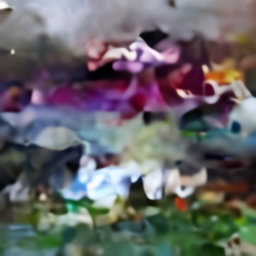

In [108]:
z = hidden_out.reshape(10, 32, 32)[2][None,...]
z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()

dec = dec.to(device)
x_stats = dec(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

display_markdown('Reconstructed image:')
display(x_rec)

Original Image:


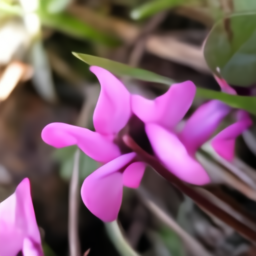

In [109]:
z = y.reshape(10, 32, 32)[2][None,...]
z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()

dec = dec.to(device)
x_stats = dec(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

display_markdown('Reconstructed image:')
display(x_rec)

Although work, but bad performance.